In [90]:
# Functions for deltaF/F EWMA-smoothing (optimized for 30Hz/resonant images, Konnerth lab, see references within)
# Added by jcoleman 9/3/24 (also see MATLAB functions added in folder)

import math
import numpy as np
from collections import OrderedDict

def smoothed_z (z, L):
    """
    Computes the exponentially weighted moving average (EWMA, with memory L) of input data z.
    Ported from original MATLAB function to Python by Z. Royston (Coleman lab):
    
    z is an input vector/1D array
    L is a time window in s
    
    # Example
    #j = [[5,5,6,7,8,1,2,9],[2,3,4,1,5,2,4,8]]
    #l = 16
    #
    #s = smoothed_z(j, l)
    #
    #print(s)
    """

    lam = 1-2/(L+1)

    smoothed = z[:] #'slice' the input array (i.e. copy)

    for j in range(1, len(z)):
        smoothed[j] = lam * smoothed[j-1] + (1-lam) * z[j]

    return smoothed

def run_deltaf_ewma(data, t_0, t_1, t_2, samplingfreq):         
    #import process_function_jc as pf
    # JUST USE def process_function(), def smooth() below    
    """
    From Konnerth lab Nature Protocols paper, for 30Hz:
    t_0 = 0.2
    t_1 = 0.75
    t_2 = 3
    samplingfreq = 30
    """   
    dff = OrderedDict()
    dff_ewma = OrderedDict()
    dff_offset = []
    for i in range(len(data)):
        dff[i], dff_ewma[i], dff_offset = pf.process_function(data[i], t_0, t_1, t_2, samplingfreq)
    if dff_offset > 0:
        dffnans = np.zeros(dff_offset)
        dffnans[:] = np.NAN
        for j in range(len(dff)):
            dff[j] = np.append(dffnans,dff[j])
            dff_ewma[j] = np.append(dffnans,dff_ewma[j])           
    return dff, dff_ewma, dff_offset

def smooth(signal, span):
    
    final = []

    l = len(signal)
    neighbors = span // 2

    for i in range(l):
        sum = 0
        if (i < neighbors):
            sp = i

        elif ((neighbors+i) >  l-1):
            sp = (l-1)-i

        else:
            sp = neighbors

        for j in range(int(i-sp), int(i+sp+1)):
            sum+=signal[j]

        final.append(sum/((sp*2)+1))
        
    """
    # smooth() test
    #F = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    #G = smooth(F, 3)
    #print(G)
    """

    return final

def process_function(signalin, t_0, t_1, t_2, Fs):
    """
    Ported from original MATLAB function to Python by Z. Royston (Coleman lab):
    Implementation of Nature protocol
    Hongbo Jia, Nathalie L Rochefort1, Xiaowei Chen & Arthur Konnerth1 "In
    vivo two-photon imaging of sensory-evoked dendritic calcium signals in cortical neurons"

    Implementation copyright Petros Xanthopoulos 2013-2014
    usage: signalout=process_function(signalin,t_0,t_1,t_2,Fs)
    where input: signalin is the raw signal 
    t_0,t_1,t_2 are the parameters described in Nature protocol paper
    comments: for a 30Hz (Fs) imaging systems the following parameter setup is
    recommended (empirical note on Nature paper): 
    Fs = 30
    t_0= 0.2;
    t_1=0.75;
    t_2=3;
    
    9/24/16 - validated by JEC
    """

    F_0 = []

    t_0_s = math.floor(t_0 * Fs)
    t_1_s = math.floor(t_1 * Fs)
    t_2_s = int(math.floor(t_2 * Fs))

    F_sm = smooth(signalin, t_1_s)

    for i in range((t_2_s), len(signalin)):
        F_0.append(min(F_sm[i-t_2_s:i]))

    R_0 = np.divide((signalin[t_2_s:] - F_0), F_0)
    # R_0 is reduced by 90 elements, zeroed and magnitude reduced by ~10-fold
    R_0_sm = np.divide((signalin[t_2_s:] - F_0), F_0)

    R_0_sm = smoothed_z(R_0_sm, t_0_s) # exponentially weighted moving average (EWMA, with memory L)
    
    diffSignal_R0 = len(signalin) - len(R_0)

    return R_0, R_0_sm, diffSignal_R0


In [91]:
# Import CSV data into Pandas dataframe (Python 3>)

#Visual stimuli info for drifting sinusoidal gratings 
#     (0.05cpd, 10Hz drift rate interleaved with gray screen)
"""
Data are from adult Thy1-GCaMP6s (Jax, line GP4.12DKim) mice

Orientations of drifting sinusoidal gratings (x8, 50% contrast)
stims_drifting = {'stim1':0,
                  'stim2':45,
                  'stim3':90,
                  'stim4':135,
                  'stim5':180,
                  'stim6':225,
                  'stim7':270,
                  'stim8':315}

stim duration = 5s
gray (inter-stim) duration = 7s
start delay = 60sec
16200 frames (9m7s on bscope streaming)
drift rate = 3Hz? (true = 1.5?)

mon width  = 52 cm
distance = 14 cm
hoiz = 1920; vert = 1080 pix

5s, 7s gray
0,45,90,135,180,225,270,315
5 sessions
60s delay
= (16200 frames = 9m7s)
"""
import pandas as pd
from urllib.request import urlopen
# or: requests.get(url).content

# 'datadirectory' = folder path string
# Import data direct from Github
url_dataset1 = ('https://raw.githubusercontent.com/ufcolemanlab/NMCoop_Shared/main/%23Febo/thy1gcamp6s_dataset1/mThy6s2_alldrift_D4_001Z1_ROIdata.csv')
url_dataset2 = ('https://raw.githubusercontent.com/ufcolemanlab/NMCoop_Shared/main/%23Febo/thy1gcamp6s_dataset2/DATA_mThy6s2_alldrift_D5_001Z1hz1.csv')
url_dataset3 = ('https://raw.githubusercontent.com/ufcolemanlab/NMCoop_Shared/main/%23Febo/thy1gcamp6s_dataset3/DATA_mThy6s2_alldrift_D5_001Z1slowpr_002newZ.csv')

url_dataset1_PNGroiMap = "https://github.com/ufcolemanlab/NMCoop_Shared/blob/main/%23Febo/thy1gcamp6s_dataset1/MAP%20mThy6s2_alldrift_D4_001Z1_ROIdata.png?raw=true"
url_dataset2_PNGroiMap = "https://github.com/ufcolemanlab/NMCoop_Shared/blob/main/%23Febo/thy1gcamp6s_dataset2/MAP_mThy6s2_alldrift_D5_001Z1hz1.png?raw=true"
url_dataset3_PNGroiMap = "https://github.com/ufcolemanlab/NMCoop_Shared/blob/main/%23Febo/thy1gcamp6s_dataset2/MAP_mThy6s2_alldrift_D5_001Z1hz1.png?raw=true"


# url_dataset1_details?...

df1 = pd.read_csv(url_dataset1,index_col=0,parse_dates=[0])
print('dataset1 (m,n) --> ' + str(df1.shape))

df2 = pd.read_csv(url_dataset2,index_col=0,parse_dates=[0])
print('dataset2 (m,n) --> ' + str(df2.shape))

df3 = pd.read_csv(url_dataset3,index_col=0,parse_dates=[0])
print('dataset3 (m,n) --> ' + str(df3.shape))

#datadirectory = '/Users/jcoleman/Documents/--LARGE DATA--/#Febo/thy1gcamp6s data set - 1/'
#datafile = 'mThy6s2_alldrift_D4_001Z1_ROIdata.csv'

# datadirectory = '/Users/jcoleman/Documents/--LARGE DATA--/#Febo/thy1gcamp6s data set - 2/'
# datafile = 'DATA_mThy6s2_alldrift_D5_001Z1hz1.csv'

# NOTE - Stim indices for this set are not included yet
# datadirectory = '/Users/jcoleman/Documents/--LARGE DATA--/#Febo/thy1gcamp6s data set - 3/'
# datafile = 'DATA_mThy6s2_alldrift_D5_001Z1slowpr_001.csv'
# datafile = 'DATA_mThy6s2_alldrift_D5_001Z1slowpr_002newZ.csv'

# df = pd.read_csv(datadirectory + datafile)



# print("datafile size (row, column) = " + str(df.shape))



dataset1 (m,n) --> (16200, 320)
dataset2 (m,n) --> (16200, 320)
dataset3 (m,n) --> (14600, 160)


In [93]:
# Import raw intensity data as Numpy array, show ROI centroid XY locations and plot raw traces

# raw signal data for each ROI under 'RawIntDen1', etc...
# use 'RawIntDen' columns, ie the raw integrated density values/pixel brightness
#  *note IntDen columns are the same, but use the RawIntDen columns for this code per convention
# gray values between 0-64000 where 0=black, 64000=white
# Describe data - Import raw calcium traces are in "RawIntDen" columns and
# Get specific headers for analysis - choose from:
calcium_data_headers = ['Area',
                        'Mean', 
                        'X',
                        'Y',
                        'Circ',
                        'IntDen',
                        'RawIntDen',
                        'AR',
                        'Round',
                        'Solidity']

print(df.filter(like=calcium_data_headers[6]).columns)

Index(['RawIntDen1', 'RawIntDen2', 'RawIntDen3', 'RawIntDen4', 'RawIntDen5',
       'RawIntDen6', 'RawIntDen7', 'RawIntDen8', 'RawIntDen9', 'RawIntDen10',
       'RawIntDen11', 'RawIntDen12', 'RawIntDen13', 'RawIntDen14',
       'RawIntDen15', 'RawIntDen16', 'RawIntDen17', 'RawIntDen18',
       'RawIntDen19', 'RawIntDen20', 'RawIntDen21', 'RawIntDen22',
       'RawIntDen23', 'RawIntDen24', 'RawIntDen25', 'RawIntDen26',
       'RawIntDen27', 'RawIntDen28', 'RawIntDen29', 'RawIntDen30',
       'RawIntDen31', 'RawIntDen32'],
      dtype='object')


In [94]:
# Just show the 'RawIntDen' columns
df2 = df.filter(regex=calcium_data_headers[6])
print(df2)

       RawIntDen1  RawIntDen2  RawIntDen3  RawIntDen4  RawIntDen5  RawIntDen6  \
                                                                                
1           17602       20989       26255       32601       40946       33187   
2           18156       28640       34145       32478       47460       27562   
3           20166       27714       40971       26238       60221       33650   
4           16640       22489       33702       29435       47673       33869   
5           17893       39759       26319       33763       41442       38588   
...           ...         ...         ...         ...         ...         ...   
16196       17941       24319       39002       39927       50059       39550   
16197       30227       25229       26793       54767       44798       40577   
16198       27882       30178       30333       41295       49095       44854   
16199       29619       30662       29865       34942       48728       37818   
16200       22252       4997

In [95]:
# Create a Numpy array from the Pandas dataframe
import numpy as np

df2_array = df2.to_numpy()

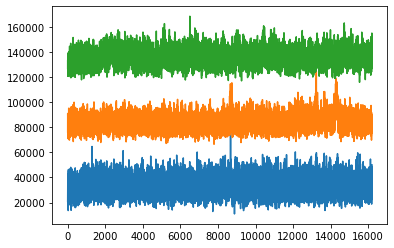

In [96]:
# Plot a few examples - individual raw data roi-traces

from matplotlib import pyplot as plt

#each row in df2_array is signal from a single region of interest (ROI = single GCaMP6s+ cell)
#plot the first 3 ROI traces (with incremental increase Y for spacing/plotting)
plt.plot(df2_array[:,1])
plt.plot(df2_array[:,2]+50000)
plt.plot(df2_array[:,3]+100000)

[ 0.72113964  0.74781819  0.49980857 ... -0.04044002 -0.02891652
  0.15925733]


Text(0.5, 1.0, 'Raw signal vs EWMA-smoothed deltaF/F')

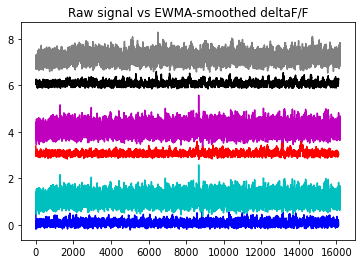

In [97]:
# Now plot a few 'EWMA-smoothed' examples - individual raw data roi-traces
"""
Ported from original MATLAB function to Python by Z. Royston (Coleman lab):
Implementation of Nature protocol
Hongbo Jia, Nathalie L Rochefort1, Xiaowei Chen & Arthur Konnerth1 "In
vivo two-photon imaging of sensory-evoked dendritic calcium signals in cortical neurons"

Implementation copyright Petros Xanthopoulos 2013-2014
usage: signalout=process_function(signalin,t_0,t_1,t_2)
where input: signalin is the raw signal 
t_0,t_1,t_2 are the parameters described in Nature protocol paper
comments: for a 30Hz (Fs) imaging systems the following parameter setup is
recommended (empirical note on Nature paper): 
Fs = 30
t_0= 0.2;
t_1=0.75;
t_2=3;
"""
# Parameters optimized for the 512x512 30Hz 2photon signals
Fs = 30 # frames per second
t_0= 0.2;
t_1=0.75;
t_2=3;

signalin1 = (df2_array[:,1])
signalout1 = process_function(signalin1,t_0,t_1,t_2,Fs)
signalin2 = (df2_array[:,2])
signalout2 = process_function(signalin2,t_0,t_1,t_2,Fs)
signalin3 = (df2_array[:,3])
signalout3 = process_function(signalin3,t_0,t_1,t_2,Fs)


from matplotlib import pyplot as plt

#each row in df2_array is signal from a single region of interest (ROI = single GCaMP6s+ cell)
#plot the first ROI trace smoothed, showing noise reduction 
print(signalout1[1])
plt.plot(signalout1[1], 'b')
plt.plot(signalin1/30000, 'c')

plt.plot(signalout2[1] + 3, 'r')
plt.plot(signalin1/30000 + 3, 'm')

plt.plot(signalout3[1] + 6, 'k')
plt.plot(signalin3/30000 + 6, 'gray')
# plt.plot(df2_array[:,2]+50000)
# plt.plot(df2_array[:,3]+100000)
plt.title('Raw signal vs EWMA-smoothed deltaF/F')

Text(0.5, 1.0, 'EWMA-smoothed deltaF/F Examples')

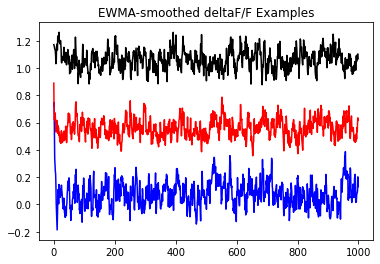

In [98]:
# Examples of EWMA-smoothed dF/F - first 1000 frames
plt.plot(signalout1[1][0:1000], 'b')

plt.plot(signalout2[1][0:1000] + .5, 'r')

plt.plot(signalout3[1][0:1000] + 1, 'k')

plt.title('EWMA-smoothed deltaF/F Examples')

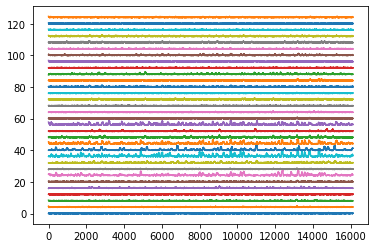

In [102]:
# Plot all 'EWMA-smoothed' roi-traces

for roi in range(len(df2_array[0])):
    #if roi>10 and roi<20:
    dff_smoothed = process_function(df2_array[:,roi],t_0,t_1,t_2,Fs)
    plt.plot(dff_smoothed[1]+roi*4)

In [ ]:
# Plot all raw data roi-traces

# for roi in range(len(df2_array[0])):
#     plt.plot(df2_array[:,roi]+roi*100000)